# Multimodal Emotion Recognition from Audio and Transcript

Sorry for bad code. I couldn't comment the code or fully train it due to lack of time. 😅

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import intel_extension_for_pytorch as ipex

import os
import librosa
import numpy as np
import whisper
from tqdm import tqdm

device = 'xpu' if torch.xpu.is_available() else 'cpu'

# Playing around with Spectrograms


In [3]:
file_path = 'dataset/Actor_01/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(file_path, sr=None)

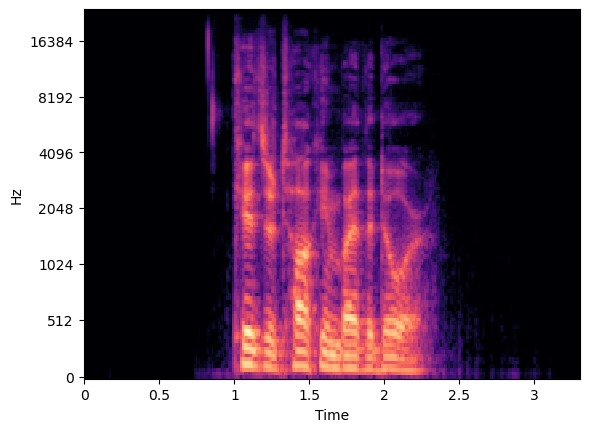

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')

# Dataset for Spectrograms


In [40]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

class SpectrogramDataset(Dataset):
    def __init__(self, transform=None):
        self.files = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                self.files.append(f'dataset/{dir}/{file}')

        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        
        # Load file and create spectrogram
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # 495 - length of longest audio file
        # -80 because that is the zero on the decibel scale
        padded = torch.zeros((1, 128, 495)) - 80
        padded[0, :, :S_dB.shape[1]] = torch.tensor(S_dB)

        # one hot encode the emotion
        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(len(emotions))
        emotion_one_hot[emotion_idx] = 1.0

        if self.transform:
            padded = self.transform(padded)

        return padded, emotion_one_hot

In [41]:
batch_size = 64

dataset = SpectrogramDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# CNN for Classifying Spectrograms

In [42]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(AudioCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # [B, 16, F, T]
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)  # [B, 16, F/2, T/2]

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)  # [B, 32, F/4, T/4]

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # [B, 64, 1, 1]

        self.fc = nn.Linear(64, num_classes)
        self.output_dim = num_classes

    def forward(self, x):  # x: [B, 1, F, T]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # [B, 64, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten: [B, 64]
        out = self.fc(x)  # [B, num_classes]
        return out
    
audio_cnn = AudioCNN(num_classes=8).to(device)

In [43]:
# Train and test the CNN

num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(audio_cnn.parameters(), lr=0.1)

test_losses = []

for epoch in range(num_epochs):
    audio_cnn.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = audio_cnn(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)

    print(f"[Epoch {epoch+1}] Training Loss: {total_loss}")

    # Validation
    audio_cnn.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = audio_cnn(X)
            loss = criterion(outputs, y)
            total_loss += loss.item() * y.size(0)

    test_losses.append(total_loss)
    print(f"Test Loss: {total_loss}\n")

KeyboardInterrupt: 

# Playing around with Whisper

In [11]:
transcriber = whisper.load_model("base")

file_path = 'dataset/Actor_01/03-01-01-01-01-01-01.wav'
result = transcriber.transcribe(file_path)
print(result['text'])

/home/shivrm/.local/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Kids are talking by the door.


# Generate Transcriptions for Everything

In [23]:
# Makes transcripts

model = whisper.load_model('tiny', device='xpu')
for dir in os.listdir('dataset'):
    for file in os.listdir(f'dataset/{dir}'):
        if os.path.exists(f'transcripts/{file}.txt'): continue

        result = model.transcribe(f'dataset/{dir}/{file}')
        open(f'transcripts/{file}.txt', 'w').write(result['text'])

KeyboardInterrupt: 

In [24]:
class TranscriptDataset(Dataset):
    def __init__(self):
        self.files = []
        self.transcripts = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                if not os.path.exists(f'transcripts/{file}.txt'): continue # In case transcript has not been generated yet
                self.files.append(f'dataset/{dir}/{file}')
                self.transcripts.append(open(f'transcripts/{file}.txt').read())
                
        self.compute_vocab()
        # Max no of tokens in a transcript
        self.padded_size = max(len(x.lower().split()) for x in self.transcripts)

    def compute_vocab(self):
        vocab = {''}
        for transcript in self.transcripts:
            vocab.update(transcript.lower().split())

        self.vocab = list(vocab)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(len(emotions))
        emotion_one_hot[emotion_idx] = 1.0

        transcript = self.transcripts[idx]
        encoded = [self.vocab.index(word) for word in transcript.lower().split()]
        encoded += [0] * (self.padded_size - len(encoded)) # Pad with zeroes

        return torch.tensor(encoded), emotion_one_hot

In [25]:
batch_size = 64

dataset = TranscriptDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# RNN for classifying transcripts

In [28]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=1, num_classes=8, bidirectional=True):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, num_classes)
        self.output_dim = hidden_dim * direction_factor  # For early fusion

    def forward(self, x):  # x: [B, T] (token IDs)
        embedded = self.embedding(x)  # [B, T, E]
        lstm_out, _ = self.lstm(embedded)  # [B, T, H*D]
        last_hidden = lstm_out[:, -1, :]   # [B, H*D]
        logits = self.fc(last_hidden)      # [B, num_classes]
        return logits

    def extract_features(self, x):
        # For early fusion
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        return lstm_out[:, -1, :]  # [B, H*D]
    
text_rnn = TextRNN(len(dataset.vocab)).to(device)

In [29]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_rnn.parameters(), lr=0.01)

test_losses = []

for epoch in range(num_epochs):
    text_rnn.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = text_rnn(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)

    print(f"[Epoch {epoch+1}] Training Loss: {total_loss}")

    # Validation
    text_rnn.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = text_rnn(X)
            loss = criterion(outputs, y)
            total_loss += loss.item() * y.size(0)

    test_losses.append(total_loss)
    print(f"Test Loss: {total_loss}\n")

[Epoch 1] Training Loss: 1486.8125286102295
Test Loss: 367.7765736579895

[Epoch 2] Training Loss: 1454.483247756958
Test Loss: 364.836443901062

[Epoch 3] Training Loss: 1424.5843048095703
Test Loss: 368.58908319473267

[Epoch 4] Training Loss: 1403.457872390747
Test Loss: 374.414945602417

[Epoch 5] Training Loss: 1392.988145828247
Test Loss: 376.7424464225769

[Epoch 6] Training Loss: 1385.5153913497925
Test Loss: 377.67391324043274

[Epoch 7] Training Loss: 1378.2222785949707
Test Loss: 370.8766939640045

[Epoch 8] Training Loss: 1367.527660369873
Test Loss: 376.3794686794281

[Epoch 9] Training Loss: 1359.9957180023193
Test Loss: 378.7666118144989

[Epoch 10] Training Loss: 1350.8333530426025
Test Loss: 385.56115078926086

[Epoch 11] Training Loss: 1335.461748123169
Test Loss: 386.6420364379883

[Epoch 12] Training Loss: 1334.5259685516357
Test Loss: 385.1304545402527

[Epoch 13] Training Loss: 1326.995548248291
Test Loss: 383.4813356399536

[Epoch 14] Training Loss: 1326.70973587

# Early Fusion Model

In [66]:
class EarlyFusionModel(nn.Module):
    def __init__(self, audio_model, text_model, fusion_dim=256, num_classes=8):
        super().__init__()
        self.audio_model = audio_model
        self.text_model = text_model

        self.fusion = nn.Sequential(
            nn.Linear(8 + text_model.output_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Linear(fusion_dim, num_classes)

    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model(audio_input)             # [B, D1]
        text_feat = self.text_model.extract_features(text_input)  # [B, D2]

        fused = torch.cat((audio_feat, text_feat), dim=1)      # [B, D1 + D2]
        fused = self.fusion(fused)
        return self.classifier(fused)
    
# Freeze earlier models
for param in audio_cnn.parameters():
    param.requires_grad = False

for param in text_rnn.parameters():
    param.requires_grad = False

early_model = EarlyFusionModel(audio_cnn, text_rnn).to(device)

In [57]:
# Gives both spectrogram and transcript

class CombinedDataset(Dataset):
    def __init__(self):
        self.files = []
        self.transcripts = []
        for dir in os.listdir('dataset'):
            for file in os.listdir(f'dataset/{dir}'):
                if not os.path.exists(f'transcripts/{file}.txt'): continue
                self.files.append(f'dataset/{dir}/{file}')
                self.transcripts.append(open(f'transcripts/{file}.txt').read())

        self.compute_vocab()

    def compute_vocab(self):
        vocab = {''}
        for transcript in self.transcripts:
            vocab.update(transcript.lower().split())

        self.vocab = list(vocab)
        self.padded_size = max(len(x.lower().split()) for x in self.transcripts)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]

        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        padded = torch.zeros((1, 128, 495)) - 80
        padded[0, :, :S_dB.shape[1]] = torch.tensor(S_dB)

        emotion_idx = int(file_path.split('-')[2]) - 1
        emotion_one_hot = torch.zeros(len(emotions))
        emotion_one_hot[emotion_idx] = 1.0

        transcript = self.transcripts[idx]
        encoded = [self.vocab.index(word) for word in transcript.lower().split()]
        encoded += [0] * (self.padded_size - len(encoded)) # Pad with zeroes

        return padded, torch.tensor(encoded), emotion_one_hot


In [58]:
batch_size = 64

dataset = CombinedDataset()
train_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [65]:
# Train the FFN part of the early fusion model

num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_rnn.parameters(), lr=0.01)

for epoch in range(num_epochs):
    early_model.train()
    total_loss = 0

    for X1, X2, y in train_loader:
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = early_model(X1, X2)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)

    print(f"[Epoch {epoch+1}] Training Loss: {total_loss}")

    # Validation
    early_model.eval()
    total_loss = 0
    with torch.no_grad():
        for X1, X2, y in test_loader:
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)
            outputs = early_model(X1, X2)
            loss = criterion(outputs, y)
            total_loss += loss.item() * y.size(0)

    test_losses.append(total_loss)
    print(f"Test Loss: {total_loss}\n")


[Epoch 1] Training Loss: 1480.1921463012695
Test Loss: 368.42642068862915

[Epoch 2] Training Loss: 1479.383415222168
Test Loss: 368.42643690109253



KeyboardInterrupt: 

# Late fusion model

In [69]:
class LateFusionModel(nn.Module):
    def __init__(self, audio_model, text_model):
        super().__init__()
        self.audio_model = audio_model  # Should output logits [B, num_classes]
        self.text_model = text_model    # Should output logits [B, num_classes]
    
    def forward(self, audio_input, text_input):
        audio_logits = self.audio_model(audio_input)
        text_logits = self.text_model(text_input)

        return (audio_logits + text_logits) / 2

late_model = LateFusionModel(audio_cnn, text_rnn)

In [71]:
# Test the late fusion model

total_loss = 0

with torch.no_grad():
    for X1, X2, y in test_loader:
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)
        outputs = late_model(X1, X2)
        loss = criterion(outputs, y)
        total_loss += loss.item() * y.size(0)

print(f"Test Loss: {total_loss}\n")

Test Loss: 329.0781502723694

